# MLflow Quick Start: Training and Logging

### Write Your ML Code Based on thetrain_diabetes.py Code
This tutorial is based on the MLflow's train_diabetes.py example, which uses the sklearn.diabetes built-in dataset to predict disease progression based on various factors.

In [1]:
# Import various libraries including matplotlib, sklearn, mlflow
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# Import mlflow
import mlflow
import mlflow.sklearn

# Load Diabetes datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame for sklearn ElasticNet linear_model
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

/home/hadoop/anaconda/envs/mlflow_test/lib/python3.6/site-packages/mlflow/utils/environment.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  env = yaml.load(_conda_header)


### Plot the ElasticNet Descent Path
As an example of recording arbitrary output files in MLflow, we'll plot the ElasticNet Descent Path for the ElasticNet model by alpha for the specified l1_ratio.

The plot_enet_descent_path function below:

* Returns an image that can be displayed in our Databricks notebook via display
* As well as saves the figure ElasticNet-paths.png to the Databricks cluster's driver node
* This file is then uploaded to MLflow using the log_artifact within train_diabetes

In [4]:
def plot_enet_descent_path(X, y, l1_ratio):
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path

    # Reference the global image variable
    global image
    
    print("Computing regularization path using the elastic net.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    # Display results
    fig = plt.figure(1)
    ax = plt.gca()

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")

    # Close plot
    plt.close(fig)

    # Return images
    return image    

### Organize MLflow Runs into Experiments
As you start using your MLflow server for more tasks, you may want to separate them out. MLflow allows you to create [experiments](https://mlflow.org/docs/latest/tracking.html#organizing-runs-in-experiments) to organize your runs. To report your run to a specific experiment, pass an experiment name to mlflow.set_experiment.

In [7]:
mlflow.set_tracking_uri('http://YOUR_EC2_PUBLIC_DNS_HERE:5000')

In [8]:
mlflow.set_experiment("/Shared/experiments/DiabetesModel")

INFO: '/Shared/experiments/DiabetesModel' does not exist. Creating a new experiment


### Train the Diabetes Model
The next function trains Elastic-Net linear regression based on the input parameters of alpha (in_alpha) and l1_ratio (in_l1_ratio).

In addition, this function uses MLflow Tracking to record its

* parameters
* metrics
* model
* arbitrary files, namely the above noted Lasso Descent Path plot.

Tip: We use with `mlflow.start_run`: in the Python code to create a new MLflow run. This is the recommended way to use MLflow in notebook cells. Whether your code completes or exits with an error, the with context will make sure that we close the MLflow run, so you don't have to call `mlflow.end_run` later in the code.

In [9]:
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
def train_diabetes(data, in_alpha, in_l1_ratio):
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2

  warnings.filterwarnings("ignore")
  np.random.seed(40)

  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)

  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]

  if float(in_alpha) is None:
    alpha = 0.05
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.05
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model")
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")

### Experiment with Different Parameters
Now that we have a train_diabetes function that records MLflow runs, we can simply call it with different parameters to explore them. Later, we'll be able to visualize all these runs on our MLflow tracking server.

In [10]:
# Start with alpha and l1_ratio values of 0.01, 0.01
train_diabetes(data, 0.01, 0.01)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
  RMSE: 71.40362571026475
  MAE: 60.09124839565383
  R2: 0.2291130640003659
Computing regularization path using the elastic net.


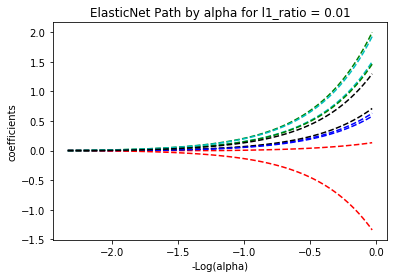

In [11]:
display(image)

In [12]:
# Start with alpha and l1_ratio values of 0.01, 0.75
train_diabetes(data, 0.01, 0.75)

Elasticnet model (alpha=0.010000, l1_ratio=0.750000):
  RMSE: 65.28994906390733
  MAE: 53.75914828434926
  R2: 0.35547047607749416
Computing regularization path using the elastic net.


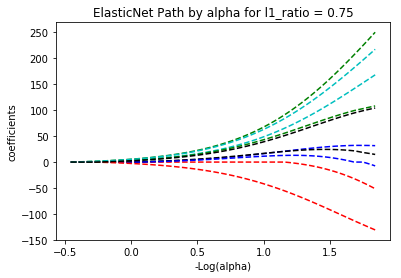

In [13]:
display(image)

In [14]:
# Start with alpha and l1_ratio values of 0.01, 1
train_diabetes(data, 0.01, 1)

Elasticnet model (alpha=0.010000, l1_ratio=1.000000):
  RMSE: 63.24666777876805
  MAE: 51.05182860408632
  R2: 0.3951809598912357
Computing regularization path using the elastic net.


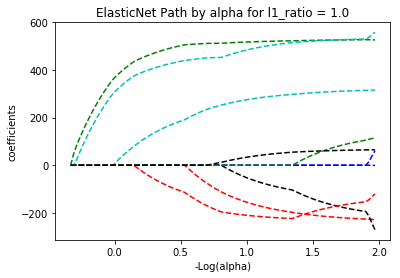

In [15]:
display(image)

### Review the experiment
Open the experiment `/Shared/experiments/DiabetesModel` in the [workspace](http://ec2-52-82-53-150.cn-northwest-1.compute.amazonaws.com.cn:5000/#/).
Click a date to view a run.